In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression, f_classif

# Загрузка данных

In [49]:
data = pd.read_excel('data/data_ford_price.xlsx') 

In [50]:
data.head()

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
4,13865,2010,3,8,166062,clean,automatic,4wd,NaN,49.210949,-123.114720,NaN


# Предобработка данных

In [51]:
#удаляем пропуски
data.dropna(inplace = True)

In [52]:
#кодируем признаки
columns_to_change = ['cylinders', 'title_status', 'transmission', 'drive', 'size']
 
one_hot_encoder = OneHotEncoder()
 
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
data_onehot = one_hot_encoder.fit_transform(data[columns_to_change]).toarray() 
# запишем полученные названия новых колонок в отдельную переменную
column_names = one_hot_encoder.get_feature_names(columns_to_change)
data_onehot = pd.DataFrame(data_onehot, index=data.index, columns=column_names)
data_new = pd.concat([data, data_onehot], axis=1)
data_new = data_new.drop(columns=columns_to_change)

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


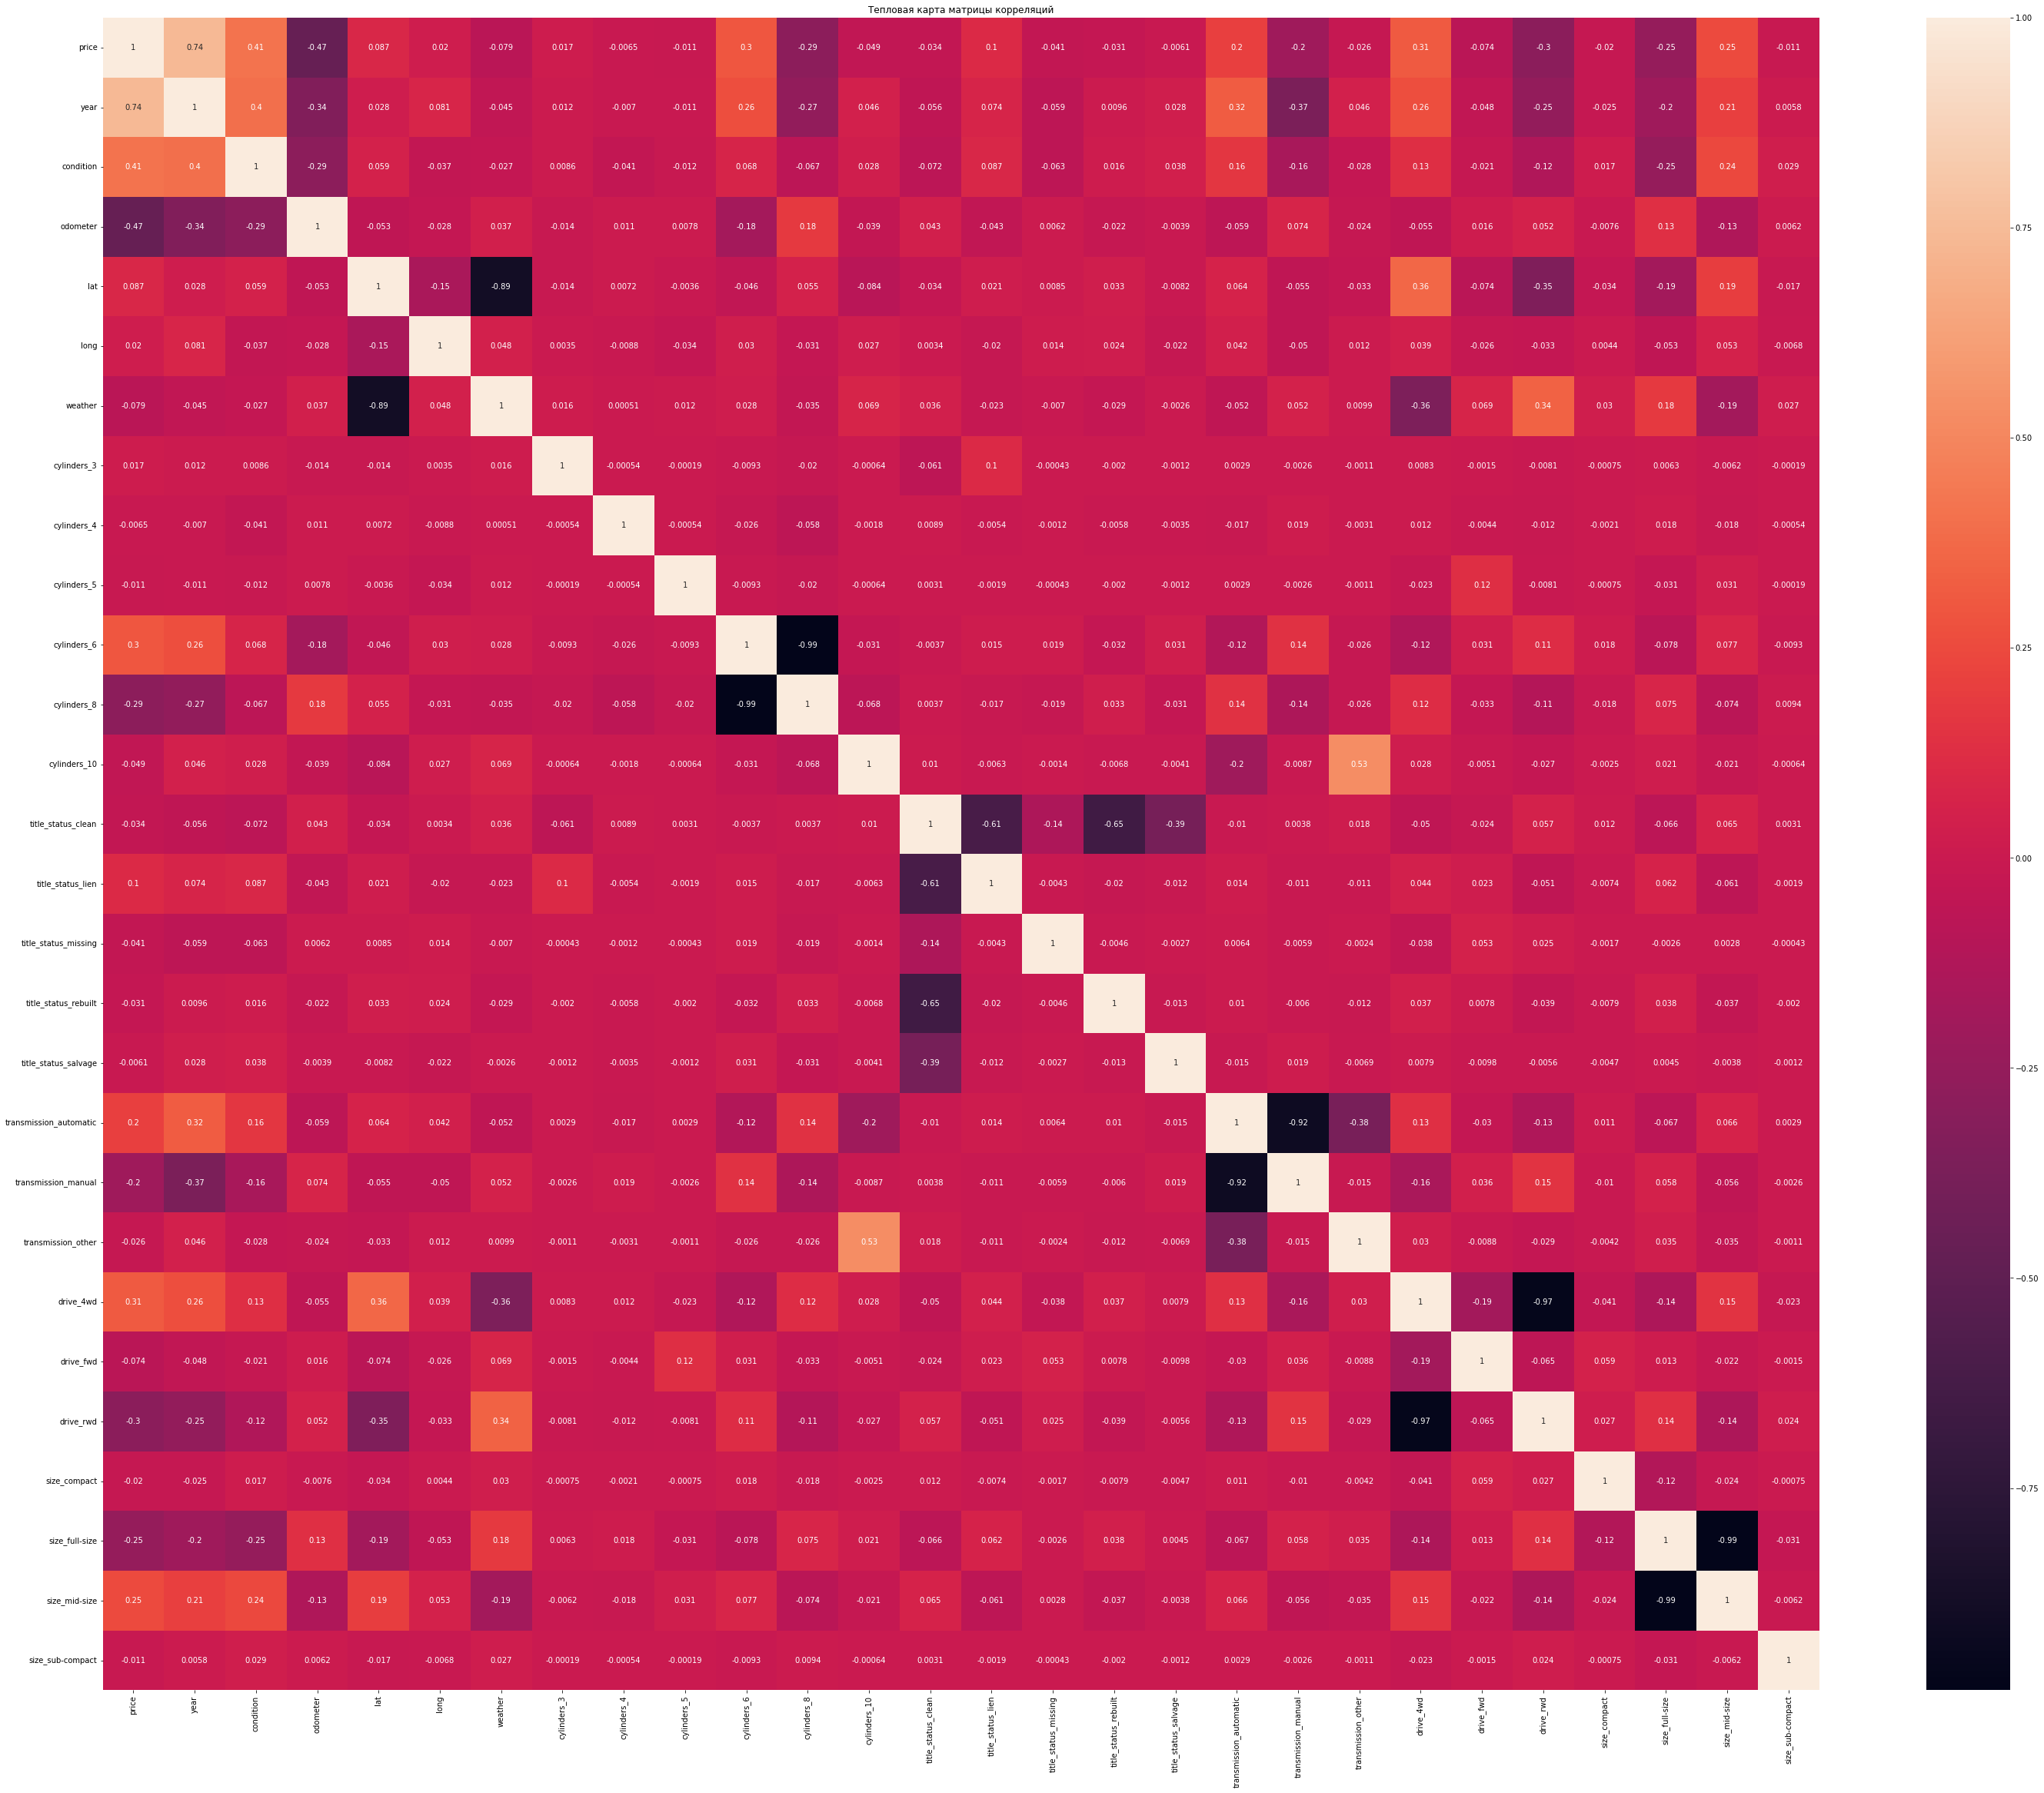

In [53]:
plt.figure(figsize=(50,40))
fig6 = sns.heatmap(data_new.corr(), annot=True) # включаем отображение коэффициентов
fig6.set_title("Тепловая карта матрицы корреляций")
plt.show()

In [54]:
# удаляем избыточные признаки (если есть мультиколлинеарность)
col_del=['lat', 'cylinders_8', 'transmission_manual', 'drive_4wd', 'size_full-size']
data_new.drop(col_del, axis = 1, inplace = True)

In [59]:

y = data_new['price']
x = data_new.drop(columns='price')

In [60]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

In [61]:
# изначальная модель
model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4355.284


# Отбор признаков RFE и построение регрессии

In [62]:
# поиск 3х признаков по RFE
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['title_status_missing', 'transmission_automatic',
       'transmission_other'], dtype=object)

In [63]:
# построение модели по RFE
x_rfe = data_new[['title_status_missing', 'transmission_automatic', 'transmission_other']]
y_rfe = data_new['price']
X_train, X_test, y_train, y_test = train_test_split(x_rfe, y_rfe, test_size=0.3, random_state=40)
model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 8371.983


модель вышла хуже, чем изначальная по всем признакам.

# Отбор признаков SelectKBest и построение модели

у нас в данных есть числовые и категориальные признаки, поэому использовать один вариант для SelectKBest не получится. попробуем несколько разных вариантов и потом выберем
1. Можно получить k/2 признаков числовых и категориальных и так построить модель, но получить 1,5 признака не получится.
2. Сначала определим лучшие 3 числовых признака  и построим модель, посмотрим mae
3. потом определим 3 категориальных признака и построим модель, определим mae
4. попробуем скомбинировать и построить модель.

In [64]:
# возьмем числовые признаки
y = data_new['price']
x = data_new[['year', 'condition', 'odometer', 'long', 'weather']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

In [65]:
selector = SelectKBest(f_regression, k=3)
selector.fit(X_train, y_train)
selector.get_feature_names_out()

array(['year', 'condition', 'odometer'], dtype=object)

In [67]:
# построение модели
x_kbest1 = data_new[['year', 'condition', 'odometer']]
y_kbest1 = data_new['price']
X_train, X_test, y_train, y_test = train_test_split(x_kbest1, y_kbest1, test_size=0.3, random_state=40)
model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4660.119


показатель mae у модели, построенной по лучшим числовым показателям сильно лучше, чем показатель у модели, построенной по лучшим показателям на основе RFE. 
попробуем построить модель по лучшим категориальным признакам и сравнить показатели.

In [68]:
y = data_new['price']
x = data_new[['cylinders_3', 'cylinders_4', 'cylinders_5', 'cylinders_6', 'cylinders_10', 'title_status_clean',
              'title_status_lien', 'title_status_missing', 'title_status_rebuilt', 'title_status_salvage', 
              'transmission_automatic', 'transmission_other', 'drive_fwd', 'drive_rwd', 'size_compact', 
              'size_mid-size', 'size_sub-compact']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

In [69]:
selector = SelectKBest(f_classif, k=3)
selector.fit(X_train, y_train)
selector.get_feature_names_out()

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0 2] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


array(['cylinders_6', 'drive_rwd', 'size_mid-size'], dtype=object)

In [70]:
# построение модели
x_kbest2 = data_new[['cylinders_6', 'drive_rwd', 'size_mid-size']]
y_kbest2 = data_new['price']
X_train, X_test, y_train, y_test = train_test_split(x_kbest2, y_kbest2, test_size=0.3, random_state=40)
model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 7374.819


mae модели, построенной по kbest с категориальными признаками, лучше чем mae модели, построенной по rfe, но хуже чем mae модели с только числовыми показателями.
попробуем теперь построить модель, куда возьмем 2 числовых показателя и одни категориальный

In [71]:
# возьмем числовые признаки
y = data_new['price']
x = data_new[['year', 'condition', 'odometer', 'long', 'weather']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)
selector = SelectKBest(f_regression, k=2)
selector.fit(X_train, y_train)
selector.get_feature_names_out()

array(['year', 'odometer'], dtype=object)

In [72]:
# определим категориальный признак
y = data_new['price']
x = data_new[['cylinders_3', 'cylinders_4', 'cylinders_5', 'cylinders_6', 'cylinders_10', 'title_status_clean',
              'title_status_lien', 'title_status_missing', 'title_status_rebuilt', 'title_status_salvage', 
              'transmission_automatic', 'transmission_other', 'drive_fwd', 'drive_rwd', 'size_compact', 
              'size_mid-size', 'size_sub-compact']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)
selector = SelectKBest(f_classif, k=1)
selector.fit(X_train, y_train)
selector.get_feature_names_out()

c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0 2] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\TrushkinaE\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


array(['size_mid-size'], dtype=object)

In [73]:
# построение модели
x_kbest3 = data_new[['year', 'odometer', 'size_mid-size']]
y_kbest3 = data_new['price']
X_train, X_test, y_train, y_test = train_test_split(x_kbest3, y_kbest3, test_size=0.3, random_state=40)
model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4701.491


у данной модели, где 2 числовых признака и один категориальный, mae хуже. чем у модели с только категориальными признаками.

дополнительно попробуем определить с помощью метода rfe лучшие признаки по числовым признакам (мы видим, что метрика по модели с только числовыми признаками выше, чем метрика по модели с смешенным набором признаков).

In [74]:
# возьмем числовые признаки
y = data_new['price']
x = data_new[['year', 'condition', 'odometer', 'long', 'weather']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)
# поиск 3х числовых признаков по RFE
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)
selector.get_feature_names_out()

array(['year', 'condition', 'weather'], dtype=object)

In [75]:
# построение модели по RFE
x_rfe2 = data_new[['year', 'condition', 'weather']]
y_rfe2= data_new['price']
X_train, X_test, y_train, y_test = train_test_split(x_rfe2, y_rfe2, test_size=0.3, random_state=40)
model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 5130.424


Итого мы построили следующие модели
1. модель с всеми параметрами, mae = 4355.284
2. модель с отобранными по RFE признаками из всех признаков. mae = 8371.983
3. модель с отобранными по selectKbest числовыми признаками, mae = 4660.119
4. модель с отобранными по selectKbest категориальными признаками, mae = 7374.819
5. модель с отобранными по selectKbest 2 числовыми и одним категориальным признаком, mae = 4701.491
6. модель с отобранными по RFE числовыми признаками. mae = 5130.424

Итого лучшей получилась модель, построенная по всем признакам. Если же сравнивать модели, построенные по выбранным параметрам, то лучшей моделью оказалась модель с отобранными по selectKbest числовыми признаками.